# CORD-19 NLP Workflow

## Dataset Overview

The CORD-19 dataset [url](https://www.semanticscholar.org/cord19) is an open dataset curated by the Allen Institute for AI intended to facilitate NLP research efforts pertaining to COVID-19. It provides a compilation of relevant peer-reviewed research publications from queries to the following sources: 

- PubMed's open access corpus
- The WHO's open access corpus
- bioRxiv and medRxiv preprints

The CORD-19 dataset is updated daily, with a .csv of publication metadata provided as well as full text (as available) from articles in JSON format. This dataset is part of a number of NLP research efforts, and is a current Kaggle challenge dataset [url](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge).

## Workflow Overview

Our goal is to provide a workflow for automating data preparation, processing, and resources for analyses of this dataset. We chose this dataset in part due to its timeliness and relevance, as well as its recurring updates; indeed, it lends itself well to automation. Having a workflow of this sort also foments experiment repeatability and provenance, two crucial elements in accountable AI. 

With this in mind, we provide below our means for:

- Acquiring the dataset
- Preparing and processing the data of interest
- Generating summary information 

We chose to focus on the abstract details in the metadata.csv file provided by CORD-19 and the associated full text provided in the pdf_json directory. The former file provides full abstracts from publications, while the latter files provide complete text, both of which we utilize for unsupervised topic modeling via LDA.

First we'll import our libraries. We'll use spacy for extracting tokens from the abstracts, nltk for its stopwords corpus as we found it to be more comprehensive than spacy's, gensim to generate a corpus and LDA model, and plotting libraries for visualizing summaries.  


In [1]:
import csv
import os
import json
from collections import defaultdict
import tqdm
from itertools import islice

import numpy as np
import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
spacy.prefer_gpu()

from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_lg 

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

import nltk
from nltk.corpus import stopwords 
import pyLDAvis.gensim

We'll first acquire the dataset and extract it. 

In [2]:
dataset_date='2020-07-16'
dataset_filename = 'cord-19_' + dataset_date + '.tar.gz'
dataset_url = 'https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases/' + dataset_filename
if os.path.exists(dataset_date) != True:
    !wget -nc "$dataset_url"
    !tar -xzf "$dataset_filename"
os.chdir(dataset_date)
!tar -xzf document_parses.tar.gz

Next we'll load spacy, and add our own set of words to the NLTK stopwords set, then update spacy's default stop_words set. By doing this, we reduce the potential for generally unique but dataset specific uninteresting and expected words to appear in our topic lists.

In [3]:
nlp= spacy.load("en_core_web_lg")
stop_words = stopwords.words('english')
stop_words.extend(['sars','covid-19', 'cov-2','=','from', 'subject', 're', 'edu', 'use', 'not', 
                   'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 
                   'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 
                   'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 
                   'line', 'even', 'also', 'may', 'take', 'come'])

nlp.Defaults.stop_words.update(stop_words)

Much like we are looking to automate this work on a macro level, we're also fans of the pipeline infrastructure spacy provides, so we define two steps of our NLP pipeline below and add them to our spacy instance. Namely, preprocessing the text provided by splitting into tokens and removing punctuation, stop words, and numerics. 

In [4]:
def lemmatize(doc):
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def clean_tokens(doc):
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True and (len(token)<=4)!=True]
    return doc

In [5]:
nlp.add_pipe(lemmatize,name='lemmatize',after='ner')
nlp.add_pipe(clean_tokens, name="cleanup", last=True)

Now we're ready to extract our abstract and publication data from metadata.csv, as well as the full text from the json-ified publication files. We then process each extracted piece of data through our spacy pipeline, then add it to a running list of abstracts and full text. For purposes of resource reduction and speed, the `dataset_limit` variable is provided below. This can be modified to process the entire dataset accordingly. 

In [6]:
fulltext_list = []
abstract_list = []
nlp.max_length = 2000000
dataset_limit = 100

with open('metadata.csv') as f_in:
    reader = csv.DictReader(f_in)
    for row in tqdm.tqdm_notebook(islice(reader, 0, dataset_limit),total=dataset_limit):
        abstract = row['abstract']
        all_text = []
        if row['pdf_json_files']:
            for json_path in row['pdf_json_files'].split('; '):
                with open(json_path) as f_json:
                    full_text_dict = json.load(f_json)
                    for paragraph_dict in full_text_dict['body_text']:
                        paragraph_text = paragraph_dict['text']
                        section_name = paragraph_dict['section']
                        all_text.append(paragraph_text)
        nlp_abstract = nlp(abstract)
        abstract_list.append(nlp_abstract)
        nlp_fulltext = nlp(u' '.join(all_text))
        fulltext_list.append(nlp_fulltext)                                

/home/jason/.venvs/720/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


With our document lists in place, we are ready to generated our word dictionary and corpus for abstracts and full text, which we then can use to (finally) create an LDA model of our documents!

In [7]:
def generate_corpus(doc_list):
    words=corpora.Dictionary(doc_list)
    corpus = [words.doc2bow(doc) for doc in doc_list]
    return [words,corpus]

def generate_lda_model(words,corpus):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=words,
                                            num_topics=10, 
                                            random_state=2,
                                            update_every=1,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)  
    return lda_model

In [8]:
gen_corp = generate_corpus(abstract_list)
abstract_words=gen_corp[0]
abstract_corpus=gen_corp[1]
abstract_lda_model = generate_lda_model(abstract_words,abstract_corpus)

In [9]:
gen_corp = generate_corpus(fulltext_list)
fulltext_words=gen_corp[0]
fulltext_corpus=gen_corp[1]
fulltext_lda_model = generate_lda_model(fulltext_words,fulltext_corpus)

As we now have LDA models generated, we can visualize our analyses. Below we generate word clouds for our topics. Followed by a pyLDAvis gensim specific topic modeling plot showing word strength within topics and distance between topic clusters.

In [10]:
def plotWordcloud(lda_model,stop_words):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    cloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = lda_model.show_topics(formatted=False)

    fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    return plt

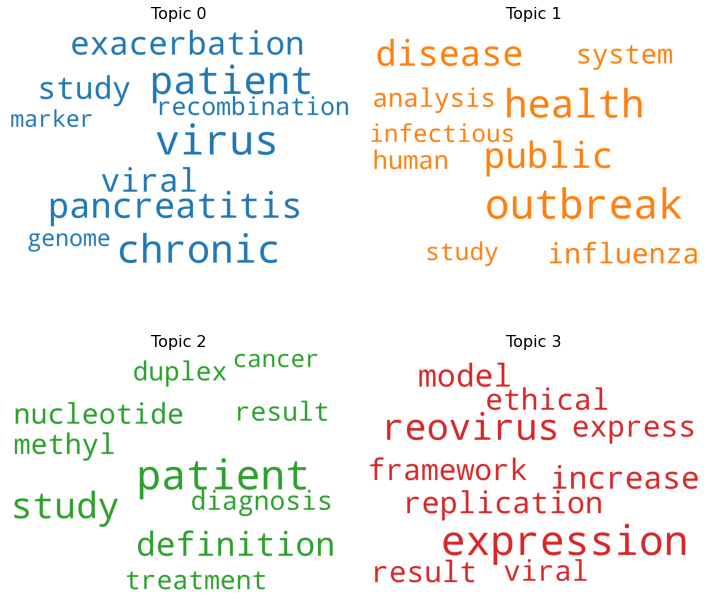

In [11]:
abstract_wordcloud = plotWordcloud(abstract_lda_model, stop_words)

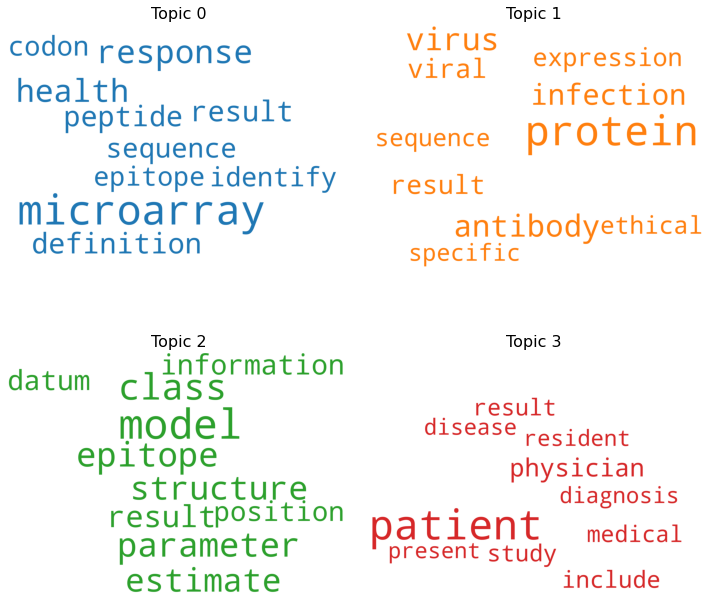

In [12]:
fulltext_wordcloud = plotWordcloud(fulltext_lda_model, stop_words)

In [13]:
pyLDAvis.enable_notebook()                           

In [14]:
abstract_ldavis = pyLDAvis.gensim.prepare(abstract_lda_model, abstract_corpus, dictionary=abstract_lda_model.id2word)
abstract_ldavis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.020782  0.038652       1        1  17.848434
3      0.029387 -0.021934       2        1  13.143173
1      0.052394  0.092501       3        1  12.092770
5      0.095647 -0.089697       4        1  10.866549
8     -0.119970 -0.079797       5        1   8.444735
9      0.007513  0.116233       6        1   8.292899
0      0.059661 -0.039436       7        1   8.119721
7     -0.183123  0.013462       8        1   7.409105
4      0.027048 -0.105865       9        1   7.037742
2      0.010662  0.075880      10        1   6.744867, topic_info=            Term       Freq      Total Category  logprob  loglift
49       patient  41.000000  41.000000  Default  30.0000  30.0000
468     outbreak  28.000000  28.000000  Default  29.0000  29.0000
122      protein  49.000000  49.000000  Default  28.0000  28.0000
931   microarray  23.000000  23.000000  Default  27.0000  27.0000
198        virus  64.000000  64.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
464       method   2.829959  29.210352  Topic10  -5.3657   0.3621
320       health   2.844738  53.759636  Topic10  -5.3605  -0.2427
28         datum   2.154934  26.279547  Topic10  -5.6382   0.1954
1061    separate   2.150837   6.006850  Topic10  -5.6401   1.6693
475       report   2.149814  19.445564  Topic10  -5.6405   0.4942

[618 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
649      10  0.466587  10(-3)/min
1007      7  0.906792       10(−5
1735     10  0.466431   3-gallate
2422      3  0.756144     Alberta
2161      4  0.858000     Archaea
...     ...       ...         ...
306       2  0.122898       yield
306       3  0.122898       yield
306       5  0.122898       yield
306       9  0.491590       yield
306      10  0.122898       yield

[1236 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 2, 6, 9, 10, 1, 8, 5, 3])

In [15]:
fulltext_ldavis = pyLDAvis.gensim.prepare(fulltext_lda_model, fulltext_corpus, dictionary=fulltext_lda_model.id2word)
fulltext_ldavis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.211670 -0.016925       1        1  50.928497
4     -0.069050 -0.017857       2        1   8.246767
7     -0.090788  0.024089       3        1   7.432536
1     -0.047440  0.092534       4        1   7.148629
5      0.000032  0.074125       5        1   6.896149
6      0.082615  0.021198       6        1   5.990721
8     -0.002004  0.077185       7        1   4.195915
0     -0.036472 -0.029924       8        1   4.192355
9      0.008778 -0.100320       9        1   2.761407
2     -0.057342 -0.124106      10        1   2.207022, topic_info=         Term         Freq        Total Category  logprob  loglift
1631   health  1276.000000  1276.000000  Default  30.0000  30.0000
281   patient  5229.000000  5229.000000  Default  29.0000  29.0000
800   protein  1038.000000  1038.000000  Default  28.0000  28.0000
127   contact   498.000000   498.000000  Default  27.0000  27.0000
699     model   742.000000   742.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
505   contain    22.754759   381.144470  Topic10  -5.7692   0.9951
323    relate    22.442728   316.528900  Topic10  -5.7830   1.1671
302   present    23.121708  1070.094849  Topic10  -5.7532  -0.0212
801   provide    22.440041   660.580505  Topic10  -5.7831   0.4313
367     study    22.566568  1508.818237  Topic10  -5.7775  -0.3891

[761 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
7852      3  0.925394         -portion
2095      6  0.855127            1999a
6857      3  0.927422          28s:18s
416       5  0.955261  3-nitrotyrosine
6759      9  0.901420            40mer
...     ...       ...              ...
2441      6  0.073622            yeast
2441      7  0.073622            yeast
2441      8  0.063105            yeast
2441     10  0.010517            yeast
4671      5  0.917698           Èttger

[2537 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 8, 2, 6, 7, 9, 1, 10, 3])

Next we'll move relevant pieces of this code to containerized applciations contained within OpenShift, which will then be orchestrated with an Argo workflow.